![OpenSARlab notebook banner](NotebookAddons/blackboard-banner.png)
<br>

## **Exploring SAR Time Series Data over Ecosystems and Deforestation Sites**

### **Franz J Meyer; University of Alaska Fairbanks & Josef Kellndorfer, [Earth Big Data, LLC](http://earthbigdata.com/)** 

<img style="padding:7px;" src="NotebookAddons/UAFLogo_A_647.png" width="170" align="right" /></font>

This notebook introduces you to the time series signatures over forested sites and sites affected by deforestation. The data analysis is done in the framework of *Jupyter Notebooks*. The Jupyter Notebook environment is easy to launch in any web browser for interactive data exploration with provided or new training data. Notebooks are comprised of text written in a combination of executable python code and markdown formatting including latex style mathematical equations. Another advantage of Jupyter Notebooks is that they can easily be expanded, changed, and shared with new data sets or newly available time series steps. Therefore, they provide an excellent basis for collaborative and repeatable data analysis. <br>

**This notebook covers the following data analysis concepts:**

- How to load time series stacks into Jupyter Notebooks and how to explore image content using basic functions such as mean value calculation and histogram analysis.
- How to extract time series information for individual pixels of an image.
- Typical time series signatures over forests and deforestation sites.


---

### <font face="Calibri" size="5" color='rgba(200,0,0,0.2)'> **Important Notes about JupyterHub** </font>

**Your JupyterHub server will automatically shutdown when left idle for more than 1 hour. Your notebooks will not be lost but you will have to restart their kernels and re-run them from the beginning. You will not be able to seamlessly continue running a partially run notebook.**

<br>

In [1]:
import url_widget as url_w
notebookUrl = url_w.URLWidget()
display(notebookUrl)

URLWidget()

In [2]:
from IPython.display import Markdown
from IPython.display import display

notebookUrl = notebookUrl.value
user = !echo $JUPYTERHUB_USER
env = !echo $CONDA_PREFIX
if env[0] == '':
    env[0] = 'Python 3 (base)'
if env[0] != '/home/jovyan/.local/envs/rtc_analysis':
    display(Markdown(f'<text style=color:red><strong>WARNING:</strong></text>'))
    display(Markdown(f'<text style=color:red>This notebook should be run using the "rtc_analysis" conda environment.</text>'))
    display(Markdown(f'<text style=color:red>It is currently using the "{env[0].split("/")[-1]}" environment.</text>'))
    display(Markdown(f'<text style=color:red>Select the "rtc_analysis" from the "Change Kernel" submenu of the "Kernel" menu.</text>'))
    display(Markdown(f'<text style=color:red>If the "rtc_analysis" environment is not present, use <a href="{notebookUrl.split("/user")[0]}/user/{user[0]}/notebooks/conda_environments/Create_OSL_Conda_Environments.ipynb"> Create_OSL_Conda_Environments.ipynb </a> to create it.</text>'))
    display(Markdown(f'<text style=color:red>Note that you must restart your server after creating a new environment before it is usable by notebooks.</text>'))


---

## **0. Importing Relevant Python Packages**

In this notebook we will use the following scientific libraries:

1. **[Pandas](https://pandas.pydata.org/)** is a Python library that provides high-level data structures and a vast variety of tools for analysis. The great feature of this package is the ability to translate rather complex operations with data into one or two commands. Pandas contains many built-in methods for filtering and combining data, as well as the time-series functionality.
1. **[GDAL](https://www.gdal.org/)** is a software library for reading and writing raster and vector geospatial data formats. It includes a collection of programs tailored for geospatial data processing. Most modern GIS systems (such as ArcGIS or QGIS) use GDAL in the background.
1. **[NumPy](http://www.numpy.org/)** is one of the principal packages for scientific applications of Python. It is intended for processing large multidimensional arrays and matrices, and an extensive collection of high-level mathematical functions and implemented methods makes it possible to perform various operations with these objects. 
1. **[Matplotlib](https://matplotlib.org/index.html)** is a low-level library for creating two-dimensional diagrams and graphs. With its help, you can build diverse charts, from histograms and scatterplots to non-Cartesian coordinates graphs. Moreover, many popular plotting libraries are designed to work in conjunction with matplotlib. 

In [3]:
%%capture
from pathlib import Path
from math import ceil

import pandas as pd # for DatetimeIndex
import numpy as np #for log10, mean, percentile, power
from osgeo import gdal # for GetRasterBand, Open, ReadAsArray
gdal.UseExceptions()

%matplotlib widget
import matplotlib.patches as patches  # for Rectangle
import matplotlib.pyplot as plt # for add_subplot, axis, figure, imshow, legend, plot, set_axis_off, set_data,
                                # set_title, set_xlabel, set_ylabel, set_ylim, subplots, title, twinx
plt.rcParams.update({'font.size': 12})

import opensarlab_lib as asfn
asfn.jupytertheme_matplotlib_format()


---

## **1. Load Data Stack** <img src="NotebookAddons/Deforest-MadreDeDios.jpg" width="350" style="padding:5px;" align="right" /> 

This notebook will be using a 78-image deep dual-polarization C-band SAR data stack over Madre de Dios in Peru to analyze time series signatures of vegetation covers, water bodies, and areas affected by deforestation. The C-band data were acquired by ESA's Sentinel-1 SAR sensor constellation and are available to you through the services of the [Alaska Satellite Facility](https://www.asf.alaska.edu/).

The site in question is interesting as it has experienced extensive logging over the last 10 years (see image to the right; [Monitoring of the Andean Amazon Project](https://blog.globalforestwatch.org/)). Since the 1980s, people have been clearing forests in this area for farming, cattle ranching, logging, and (recently) gold mining. Creating RGB color composites is an easy way to visualize ongoing changes in the landscape.

Before we get started, let's first **create a working directory for this analysis and change into it:**

In [6]:
path = Path.cwd()/"data_Ex2-4_S1-MadreDeDios"

if not path.exists():
    path.mkdir()


We will **retrieve the relevant data** from an [Amazon Web Service (AWS)](https://aws.amazon.com/) cloud storage bucket **using the following command**:

In [7]:
time_series_path = 's3://asf-jupyter-data-west/MadreDeDios.zip'
time_series = Path(time_series_path).name
!aws --region=us-west-2 --no-sign-request s3 cp $time_series_path $time_series

download: s3://asf-jupyter-data-west/MadreDeDios.zip to ./MadreDeDios.zip


Now, let's **unzip the file (overwriting previous extractions) and clean up after ourselves:**

In [8]:
if Path(time_series).exists():
    asfn.asf_unzip(str(path), time_series)
    Path(time_series).unlink()

Extracting: MadreDeDios.zip


<br>

## **2. Define Data Directory and Path to VRT**

**Create a variable containing the VRT filename and the image acquisition dates:**

In [9]:
!gdalbuildvrt -separate {path}/raster_stack.vrt {path}/tiffs/*_VV.tiff
image_file_VV = path/"raster_stack.vrt"
!gdalbuildvrt -separate {path}/raster_stack_VH.vrt {path}/tiffs/*_VH.tiff
image_file_VH = path/"raster_stack_VH.vrt"


0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


**Create an index of timedelta64 data with Pandas:**

In [10]:
!ls {path}/tiffs/*_VV.tiff | sort | sed 's/[^0-9]*//g' | cut -c 4-11 > {path}/raster_stack_VV.dates
datefile_VV = path/'raster_stack_VV.dates'
dates_VV = open(str(datefile_VV)).readlines()
tindex_VV = pd.DatetimeIndex(dates_VV)

!ls {path}/tiffs/*_VH.tiff | sed 's/[^0-9]*//g' | cut -c 4-11 > {path}/raster_stack_VH.dates
datefile_VH = path/'raster_stack_VH.dates'
dates_VH = open(str(datefile_VH)).readlines()
tindex_VH = pd.DatetimeIndex(dates_VH)

<br>

---

## **3. Assess Image Acquisition Dates**

Before we start analyzing the available image data, we want to examine the content of our data stack. From the date index, we **make and print a lookup table for band numbers and dates:**

In [11]:
stindex=[]
for i in [str(datefile_VV),str(datefile_VH)]:
    with open(i) as f:
        sdates = f.readlines()
    stindex.append(pd.DatetimeIndex(sdates))
    j = 1
    print('\nBands and dates for',i.strip('.dates'))
    for k in stindex[-1]:
        print("{:4d} {}".format(j, k.date()),end=' ')
        j += 1
        if j%5 == 1: 
            print()


Bands and dates for /home/jovyan/notebooks/SAR_Training/English/Ecosystems/data_Ex2-4_S1-MadreDeDios/raster_stack_VV
   1 2016-02-06    2 2016-09-09    3 2016-12-20    4 2017-01-13    5 2017-02-06 
   6 2017-03-02    7 2017-03-14    8 2017-03-26    9 2017-04-07   10 2017-04-19 
  11 2017-05-01   12 2017-05-13   13 2017-05-25   14 2017-06-06   15 2017-06-18 
  16 2017-06-30   17 2017-07-12   18 2017-07-24   19 2017-08-05   20 2017-08-17 
  21 2017-08-29   22 2017-09-10   23 2017-09-22   24 2017-10-04   25 2017-10-16 
  26 2017-10-28   27 2017-11-21   28 2017-12-03   29 2017-12-15   30 2017-12-27 
  31 2018-01-08   32 2018-01-20   33 2018-02-01   34 2018-02-13   35 2018-02-25 
  36 2018-03-09   37 2018-03-21   38 2018-04-02   39 2018-04-14   40 2018-04-26 
  41 2018-05-08   42 2018-05-20   43 2018-06-01   44 2018-06-13   45 2018-06-25 
  46 2018-07-07   47 2018-07-19   48 2018-07-31   49 2018-08-12   50 2018-08-24 
  51 2018-09-05   52 2018-09-17   53 2018-09-29   54 2018-10-11   55 201


---
<br>

## **4. Create Minimum Image to Identify Likely Areas of Deforestation**

### **4.1 Load Time Series Stack**

**First, we load the raster stack into memory and calculate the minimum backscatter in the time series:**

In [12]:
img = gdal.Open(str(image_file_VV))
band = img.GetRasterBand(1)
raster0 = band.ReadAsArray()
band_number = 0 # Needed for updates
rasterstack_VV = img.ReadAsArray()

To **explore the image (number of bands, pixels, lines),** you can use several functions associated with the image object (img) created in the last code cell: 

In [13]:
print(img.RasterCount) # Number of Bands
print(img.RasterXSize) # Number of Pixels
print(img.RasterYSize) # Number of Lines

78
1090
1102


The following line **calculates the minimum backscatter per pixel** across the time series: 

In [14]:
db_mean = np.min(rasterstack_VV, axis=0)

<br>

### **4.2 Visualize the Minimum Image and Select a Coordinate for a Time Series**

**Write a class to create an interactive plot from which we can select interesting image locations for a time series.**

In [15]:
class pixelPicker:
    def __init__(self, image, width, height):
        self.x = None
        self.y = None
        self.fig = plt.figure(figsize=(width, height))
        self.ax = self.fig.add_subplot(111, visible=False)
        self.rect = patches.Rectangle((0.0, 0.0), width, height, 
            fill=False, clip_on=False, visible=False)      
        self.rect_patch = self.ax.add_patch(self.rect)
        self.cid = self.rect_patch.figure.canvas.mpl_connect('button_press_event', 
                                                             self)
        self.image = image
        self.plot = self.gray_plot(self.image, fig=self.fig, return_ax=True)
        self.plot.set_title('Select a Point of Interest')
        
        
    def gray_plot(self, image, vmin=None, vmax=None, fig=None, return_ax=False):
        '''
        Plots an image in grayscale.
        Parameters:
        - image: 2D array of raster values
        - vmin: Minimum value for colormap
        - vmax: Maximum value for colormap
        - return_ax: Option to return plot axis
        '''
        if vmin is None:
            vmin = np.nanpercentile(self.image, 1)
        if vmax is None:
            vmax = np.nanpercentile(self.image, 99)
        #if fig is None:
        #   my_fig = plt.figure() 
        ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
        ax.imshow(image, cmap=plt.cm.gist_gray, vmin=vmin, vmax=vmax)
        if return_ax:
            return(ax)
        
    
    def __call__(self, event):
        print('click', event)
        self.x = event.xdata
        self.y = event.ydata
        for pnt in self.plot.get_lines():
            pnt.remove()
        plt.plot(self.x, self.y, 'ro')

Now we are ready to plot the minimum image. **Click a point interest for which you want to analyze radar brightness over time**:

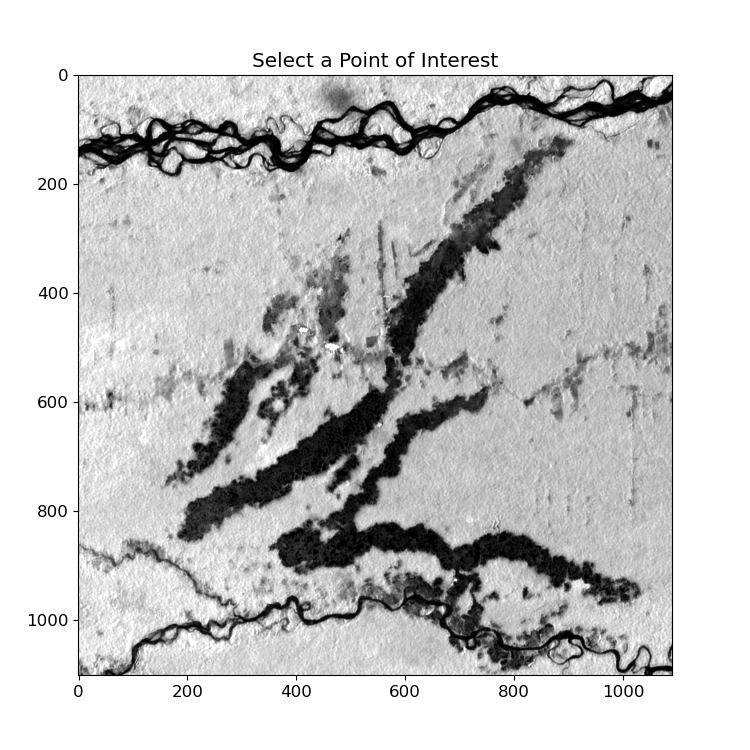

In [16]:
# Large plot of multi-temporal average of VV values to inspect pixel values
fig_xsize = 7.5
fig_ysize = 7.5
my_plot = pixelPicker(db_mean, fig_xsize, fig_ysize)

**Save the selected coordinates**

In [17]:
sarloc = (ceil(my_plot.x), ceil(my_plot.y))
print(sarloc)

(751, 585)


## **5. Plot SAR Brightness Time Series at Point Locations**

### **5.1 SAR Brightness Time Series at Point Locations**

We will pick a pixel location identified in the SAR image above and plot the time series for this identified point. By focusing on image locations undergoing deforestation, we should see the changes in the radar cross section related to the deforestation event.
    
First, for processing of the imagery in this notebook we **generate a list of image handles and retrieve projection and georeferencing information.**

In [18]:
imagelist = [str(image_file_VV), str(image_file_VH)]
geotrans = []
proj = []
img_handle = []
xsize = []
ysize = []
bands = []
for i in imagelist:
    img_handle.append(gdal.Open(i))
    geotrans.append(img_handle[-1].GetGeoTransform())
    proj.append(img_handle[-1].GetProjection())
    xsize.append(img_handle[-1].RasterXSize)
    ysize.append(img_handle[-1].RasterYSize)
    bands.append(img_handle[-1].RasterCount)

Now, let's **pick a 5x5 image area around a center pixel defined in variable _sarloc_**...

In [19]:
ref_x = geotrans[0][0] + sarloc[0]*geotrans[0][1]
ref_y = geotrans[0][3] + sarloc[1]*geotrans[0][5]
print('UTM Coordinates      ',ref_x, ref_y)
print('SAR pixel/line       ',sarloc[0], sarloc[1])
subset_sentinel = (sarloc[0], sarloc[1], 5, 5)

UTM Coordinates       397680.0 8572680.0
SAR pixel/line        751 585


... and **extract the time series** for this small area around the selected center pixel:

In [20]:
s_ts = []
for idx in (0, 1):
    means = []
    for i in range(bands[idx]):
        rs = img_handle[idx].GetRasterBand(i+1).ReadAsArray(*subset_sentinel)
        rs_means_pwr = np.mean(rs)
        rs_means_dB = 10.*np.log10(rs_means_pwr)
        means.append(rs_means_dB)
    s_ts.append(pd.Series(means, index=stindex[idx]))
        
means = []

**Create a directory in which to store our plots and animations:**

In [21]:
product_path = path/'plots_and_animations'

if not product_path.exists():
    product_path.mkdir()

**Plot the extracted time series** for VV and VH polarizations: 

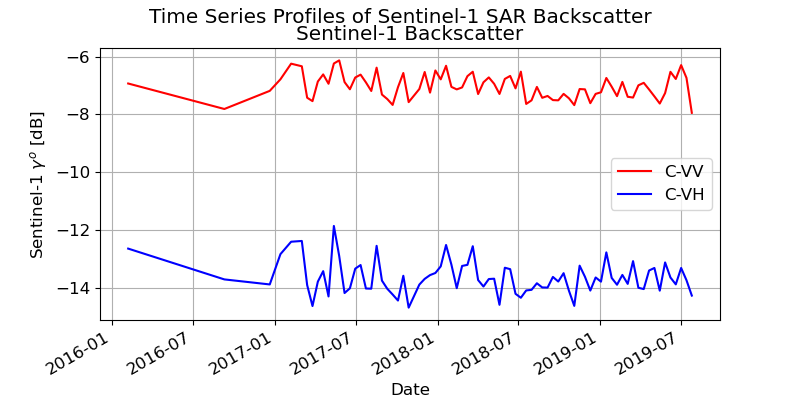

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

s_ts[0].plot(ax=ax, color='red', label='C-VV')
                                 
s_ts[1].plot(ax=ax, color='blue', label='C-VH')
ax.set_xlabel('Date')
ax.set_ylabel(r'Sentinel-1 $\gamma^o$ [dB]')

ax.set_title('Sentinel-1 Backscatter')
plt.grid()
_ = ax.legend(loc='best')
_ = fig.suptitle('Time Series Profiles of Sentinel-1 SAR Backscatter')
figname = f"RCSTimeSeries-{ref_x:.0f}_{ref_y:.0f}.png"
plt.savefig(product_path/f"{figname}", dpi=300, transparent='true')

<div class="alert alert-success">
<font face="Calibri" size="5"> <b> <font color='rgba(200,0,0,0.2)'> <u>EXERCISE</u>:  </font> Explore Time Series at Different Point Locations </b> </font>

<font face="Calibri" size="3"> Explore this data set some more by picking different point coordinates to explore. Use the time series animation together with the minimum plot to identify interesting areas and explore the radar brightness history. Discuss with your colleagues what you find.
</font>
</div>


---

*Exercise3-ExploreSARTimeSeriesDeforestation - Version 1.5.1 - February 2024*

**Version Changes:**

- *- *Pass raw strings using LaTeX to matplotlib**